In [3]:
#Libraries
from numpy import mean
from numpy import std


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score, roc_auc_score, accuracy_score, fbeta_score
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score, cross_validate,GridSearchCV
from sklearn.decomposition import PCA
#from sklearn.inspection import DecisionBoundaryDisplay
from tqdm.notebook import tqdm
import os
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
import pandas as pd
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

print(sklearn.__version__)


0.24.2


In [4]:
fp_path = './Placenta_Fingerprints/'

# prepare the cross-validation procedure
skf = StratifiedKFold(n_splits=5, random_state=7, shuffle=True)

specificity = make_scorer(recall_score,pos_label=0)
sensitivity = make_scorer(recall_score,pos_label=1)
auroc = make_scorer(roc_auc_score)

f_half = make_scorer(fbeta_score, beta=0.5)


#scoring = {"Accuracy": make_scorer(accuracy_score),'sensitivity':sensitivity, 'specificity': specificity, "AUC": "roc_auc", }

def gridsearch_for_fp(model, params, name):
    Results = {}
    Estimators = []
    print("Starting gridsearch for model:",name)
    
    for j in tqdm(range(len(os.listdir(fp_path)))):
        fingerprint = os.listdir(fp_path)[j]
        print("Model Training for:",fingerprint[:-4])
        
        #load data for FP and ground truth
        X = np.load(fp_path+fingerprint, allow_pickle=True)
        y = np.load('./placenta_target.npy',allow_pickle=True)

        #Skip FPs with single features
        if X.shape == (len(X),):
            continue

        #pre-processing and normalization
        scaler = StandardScaler()
        scaler.fit(X)
        X=scaler.transform(X)
        
        #Dimensionality Reduction
        pca = PCA(n_components = 0.95)
        X = pca.fit_transform(X)

        #Gridsearch
        imba_pipeline = Pipeline(steps=[('oversample',SMOTE(random_state=7)), 
                                  ('model',model)])
        grid_imba = GridSearchCV(imba_pipeline, param_grid=params, cv=skf, scoring='roc_auc', #refit="roc_auc",
                                return_train_score=True, verbose=1, n_jobs=-1)
        grid_imba.fit(X, y)
        print("Best Params for:", name, "for FP:",fingerprint[:-4],grid_imba.best_params_)
        print("Best ROC_AUC:", grid_imba.best_score_)

        #print(grid_imba.cv_results_)

        #Evaluation
        metrics = {'accuracy':'accuracy','sensitivity':'recall', 'specificity': specificity, 'roc_auc':'roc_auc', 'f_half':f_half}
        imba_pipeline_eval = Pipeline(steps=[('oversample',SMOTE(random_state=7)), 
                                      ('model',grid_imba.best_estimator_)])
        res = cross_validate(imba_pipeline_eval, X, y, scoring=metrics, cv=skf)

        print("Accuracy:",res['test_accuracy'].mean(),"Sensitivity:",res['test_sensitivity'].mean(),"Specificity:",res['test_specificity'].mean(), "AUROC:",res['test_roc_auc'].mean(), "f_half:", res['test_f_half'].mean())

        Estimators.append(grid_imba.best_estimator_)
        Results[fingerprint[:-4]]= (res, Estimators)
        
    return Results

#all_res_knn = gridsearch_for_fp(KNeighborsClassifier(3), grid_params, 'KNN')
# clf_res[names[i]] = Results
# #Results with PCA+SMOTE
# column_names = ['feature_set', 'Test accuracy', 'Test_Sensitivity', 'Test_Specificity', 'roc_auc']
# model_results = pd.DataFrame(columns = column_names)
# for key in Results:
#     key_res = np.mean(np.array(Results[key]), axis=0)
#     model_results.loc[len(model_results)] = [key, key_res[0], key_res[1], key_res[2], key_res[3]]
# #     #print(key,"Train ACC:", str(Results[key].history['accuracy'][idx]), "Test ACC:", str(Results[key].history['val_accuracy'][idx]), "Test AUC:", str(Results[key].history['val_auc'][idx]))
# display(model_results)





In [7]:
import pandas as pd

def print_res(all_res):
    column_names = ['feature_set', 'Test accuracy', 'Test_spec', 'Test_Sens', 'roc_auc', 'f_half']
    model_results = pd.DataFrame(columns = column_names)
    for key in all_res:
        key_res = all_res[key][0]
        model_results.loc[len(model_results)] = [key, key_res['test_accuracy'].mean(), key_res['test_specificity'].mean(), key_res['test_sensitivity'].mean(), key_res['test_roc_auc'].mean(), key_res['test_f_half'].mean()]
    
    display(model_results)
#print_res(all_res_knn)

In [23]:
knn_grid_params = {'model__n_neighbors' : [5,10,15,20,25,35,50],
               'model__weights' : ['uniform','distance'],
               'model__metric' : ['minkowski','euclidean','manhattan']}

SVC_param_grid = {'model__C': [0.1,1,10], 'model__gamma': [1,0.1,0.01,0.001],'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

# DT_param_grid = {'model__max_features': ['auto', 'sqrt', 'log2'],
#               'model__ccp_alpha': [0.1, .01, .001, 0.0001],
#               'model__max_depth' : [5, 10, 15, 20, 35, 50, 100],
#               'model__criterion' :['gini', 'entropy']
#              }

RF_param_grid = { 
    'model__n_estimators': [10, 50, 100, 200, 1000],
    'model__max_features': ['auto', 'sqrt', 'log2'],
    'model__max_depth' : [4,10,15,20,25],
    'model__criterion' :['gini', 'entropy']
}

# Adaboost_param_grid = {'model__n_estimators': [50,100,200,400,800],
#                         'model__learning_rate': [10,1,0.5,0.1,0.001]
# }

# extratrees_param_grid = {'model__n_estimators': [10, 50, 100, 200, 1000],
#     'model__max_features': ['sqrt', 'log2'],
#     'model__max_depth' : [4,10,15,20,25],
#     'model__criterion' :['gini', 'entropy'],
#     'model__class_weight': ['balanced', 'balanced_subsample']}

# GBC_param_grid = {
#     'model__loss': ['deviance', 'exponential'],
#     'model__n_estimators': [100, 200, 500],
#     'model__max_features': ['sqrt', 'log2'],
#     'model__max_depth' : [15,25],
#     'model__criterion' : ['friedman_mse', 'squared_error']
# }

# xgboost_param_grid = {"model__subsample":[0.7, 1],
#               "model__colsample_bytree":[0.7, 0.9],
#               "model__max_depth":[15],
#               "model__min_child_weight":[1,5,10],
#               "model__learning_rate":[ 0.1, 0.03]}

# catboost_param_grid = {'model__depth':[10,5],
#           'model__iterations':[100, 250],
#           'model__learning_rate':[0.001,0.01,0.1], 
#           'model__l2_leaf_reg':[1,5],
#           'model__silent':[True]}

lgbm_param_grid = {'model__learning_rate': [0.01],
'model__n_estimators': [20, 100, 500],
'model__num_leaves': [6, 12, 16],
'model__boosting_type': ['gbdt','goss'],
'model__objective': ['binary'],
'model__seed': [500],
'model__is_unbalance': [True],
'model__colsample_bytree': [0.5, 0.75, 0.9],
'model__subsample': [0.7, 0.75],
'model__reg_alpha': [2, 10],
'model__reg_lambda': [2, 10],
'model__n_jobs':[-1]}


mlp_param_grid = {
    'model__hidden_layer_sizes': [(100,100,100), (50,100,50), (100,200,100), (50,100,200,50)],
    'model__activation': ['tanh', 'relu'],
    'model__solver': ['adam'],
    'model__alpha': [0.0001, 0.05],
    'model__learning_rate': ['constant','adaptive'],
    'model__max_iter': [600]
}



In [7]:
#KNN grid search
all_res_knn = gridsearch_for_fp(KNeighborsClassifier(3), knn_grid_params, 'KNN')
print_res(all_res_knn)

Starting gridsearch for model: KNN


  0%|          | 0/22 [00:00<?, ?it/s]

Model Training for: substructure
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best Params for: KNN for FP: substructure {'model__metric': 'minkowski', 'model__n_neighbors': 5, 'model__weights': 'uniform'}
Best ROC_AUC: 0.8357336430507163
Accuracy: 0.7600177304964539 Sensitivity: 0.7524970963995354 Specificity: 0.8047619047619048 AUROC: 0.8357336430507163 f_half: 0.9096175428760211
Model Training for: mol2vec
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best Params for: KNN for FP: mol2vec {'model__metric': 'manhattan', 'model__n_neighbors': 20, 'model__weights': 'distance'}
Best ROC_AUC: 0.8346302748741774
Accuracy: 0.7256205673758865 Sensitivity: 0.7183507549361209 Specificity: 0.7809523809523811 AUROC: 0.8346302748741774 f_half: 0.8957406740569256
Model Training for: rdk-maccs
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best Params for: KNN for FP: rdk-maccs {'model__metric': 'minkowski', 'model__n_neighbors': 5, 'model__weights': '

,feature_set,Test accuracy,Test_spec,Test_Sens,roc_auc,f_half
0,substructure,0.760018,0.804762,0.752497,0.835734,0.909618
1,mol2vec,0.725621,0.780952,0.718351,0.834630,0.895741
2,rdk-maccs,0.730585,0.776190,0.723693,0.826249,0.896092
3,graph,0.759929,0.766667,0.757724,0.810376,0.908898
4,fp3,0.789450,0.680952,0.806620,0.813811,0.910662
5,hybridization,0.400266,0.966667,0.314402,0.827729,0.668220
6,avalon,0.371454,0.900000,0.291521,0.791715,0.652253
7,rdkit,0.721543,0.742857,0.718583,0.814179,0.891422
8,fp4,0.662589,0.876190,0.631127,0.849690,0.874819
9,extended,0.358067,0.966667,0.266086,0.837737,0.610536


In [8]:
#SVC grid search
all_res_SVC = gridsearch_for_fp(SVC(), SVC_param_grid, 'SVC')
print_res(all_res_SVC)

Starting gridsearch for model: SVC


  0%|          | 0/22 [00:00<?, ?it/s]

Model Training for: substructure
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Params for: SVC for FP: substructure {'model__C': 10, 'model__gamma': 0.001, 'model__kernel': 'poly'}
Best ROC_AUC: 0.8505032907471932
Accuracy: 0.7456560283687943 Sensitivity: 0.8097560975609757 Specificity: 0.32380952380952377 AUROC: 0.8505032907471932 f_half: 0.7816113150630354
Model Training for: mol2vec
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Params for: SVC for FP: mol2vec {'model__C': 1, 'model__gamma': 0.001, 'model__kernel': 'poly'}
Best ROC_AUC: 0.8274487030584592
Accuracy: 0.8820035460992907 Sensitivity: 0.9807200929152149 Specificity: 0.22857142857142856 AUROC: 0.8274487030584592 f_half: 0.9102691486689232
Model Training for: rdk-maccs
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Params for: SVC for FP: rdk-maccs {'model__C': 0.1, 'model__gamma': 0.001, 'model__kernel': 'poly'}
Best ROC_AUC: 0.8280294231513745
Accuracy: 0.27969

,feature_set,Test accuracy,Test_spec,Test_Sens,roc_auc,f_half
0,substructure,0.745656,0.323810,0.809756,0.850503,0.781611
1,mol2vec,0.882004,0.228571,0.980720,0.827449,0.910269
2,rdk-maccs,0.279699,0.833333,0.195122,0.828029,0.180995
3,graph,0.839805,0.423810,0.902787,0.791454,0.910632
4,fp3,0.239096,0.966667,0.128571,0.854346,0.175325
5,hybridization,0.215160,1.000000,0.097561,0.780468,0.298004
6,avalon,0.844149,0.709524,0.864344,0.846748,0.932988
7,rdkit,0.886082,0.352381,0.965970,0.836798,0.919545
8,fp4,0.809486,0.290476,0.887805,0.842063,0.885772
9,extended,0.890426,0.323810,0.975726,0.807753,0.918824


In [9]:
#DT grid search
all_res_DT = gridsearch_for_fp(DecisionTreeClassifier(max_depth=5), DT_param_grid, 'DT')
print_res(all_res_DT)

Starting gridsearch for model: DT


  0%|          | 0/22 [00:00<?, ?it/s]

Model Training for: substructure
Fitting 5 folds for each of 168 candidates, totalling 840 fits
Best Params for: DT for FP: substructure {'model__ccp_alpha': 0.01, 'model__criterion': 'gini', 'model__max_depth': 10, 'model__max_features': 'log2'}
Best ROC_AUC: 0.6866434378629501
Accuracy: 0.7421985815602837 Sensitivity: 0.8105691056910571 Specificity: 0.2952380952380952 AUROC: 0.5359659310878823 f_half: 0.8665832864669726
Model Training for: mol2vec
Fitting 5 folds for each of 168 candidates, totalling 840 fits
Best Params for: DT for FP: mol2vec {'model__ccp_alpha': 0.01, 'model__criterion': 'gini', 'model__max_depth': 15, 'model__max_features': 'log2'}
Best ROC_AUC: 0.7572009291521488
Accuracy: 0.7763297872340426 Sensitivity: 0.8443670150987226 Specificity: 0.3285714285714285 AUROC: 0.5809717382888115 f_half: 0.8805036593858631
Model Training for: rdk-maccs
Fitting 5 folds for each of 168 candidates, totalling 840 fits
Best Params for: DT for FP: rdk-maccs {'model__ccp_alpha': 0.01, 

,feature_set,Test accuracy,Test_spec,Test_Sens,roc_auc,f_half
0,substructure,0.742199,0.295238,0.810569,0.535966,0.866583
1,mol2vec,0.776330,0.328571,0.844367,0.580972,0.880504
2,rdk-maccs,0.785018,0.328571,0.854007,0.559563,0.883796
3,graph,0.772252,0.261905,0.849593,0.576365,0.877169
4,fp3,0.814628,0.480952,0.864808,0.654046,0.904997
5,hybridization,0.679433,0.352381,0.728107,0.546632,0.845132
6,avalon,0.801684,0.323810,0.874100,0.615602,0.890748
7,rdkit,0.759574,0.347619,0.820441,0.584030,0.877723
8,fp4,0.751152,0.261905,0.825319,0.543612,0.868990
9,extended,0.767996,0.285714,0.840186,0.572745,0.877052


In [10]:
#randomforest grid search
all_res_RF = gridsearch_for_fp(RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, n_jobs=-1), RF_param_grid, 'RF')
print_res(all_res_RF)

Starting gridsearch for model: RF


  0%|          | 0/22 [00:00<?, ?it/s]

Model Training for: substructure
Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best Params for: RF for FP: substructure {'model__criterion': 'entropy', 'model__max_depth': 10, 'model__max_features': 'auto', 'model__n_estimators': 100}
Best ROC_AUC: 0.7736546651180797
Accuracy: 0.8439716312056739 Sensitivity: 0.9320557491289199 Specificity: 0.2619047619047619 AUROC: 0.7479094076655052 f_half: 0.9006596598368303
Model Training for: mol2vec
Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best Params for: RF for FP: mol2vec {'model__criterion': 'entropy', 'model__max_depth': 15, 'model__max_features': 'auto', 'model__n_estimators': 50}
Best ROC_AUC: 0.8286488579171506
Accuracy: 0.8694148936170212 Sensitivity: 0.9419279907084785 Specificity: 0.3952380952380952 AUROC: 0.8142082849399923 f_half: 0.9170548933580139
Model Training for: rdk-maccs
Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best Params for: RF for FP: rdk-maccs {'model__criterion

,feature_set,Test accuracy,Test_spec,Test_Sens,roc_auc,f_half
0,substructure,0.843972,0.261905,0.932056,0.747909,0.900660
1,mol2vec,0.869415,0.395238,0.941928,0.814208,0.917055
2,rdk-maccs,0.873404,0.357143,0.951568,0.714566,0.915958
3,graph,0.869238,0.290476,0.956330,0.799874,0.911107
4,fp3,0.857004,0.523810,0.908595,0.821254,0.921932
5,hybridization,0.890426,0.328571,0.975842,0.728775,0.918983
6,avalon,0.864894,0.285714,0.951336,0.634108,0.909327
7,rdkit,0.898759,0.323810,0.985482,0.780614,0.921091
8,fp4,0.873493,0.290476,0.961208,0.776558,0.912362
9,extended,0.877571,0.323810,0.961208,0.764160,0.915044


In [11]:
#Adaboost grid search
all_res_ada = gridsearch_for_fp(AdaBoostClassifier(), Adaboost_param_grid, 'Adaboost')
print_res(all_res_ada)

Starting gridsearch for model: Adaboost


  0%|          | 0/22 [00:00<?, ?it/s]

Model Training for: substructure
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Params for: Adaboost for FP: substructure {'model__learning_rate': 0.5, 'model__n_estimators': 400}
Best ROC_AUC: 0.7656794425087109
Accuracy: 0.8312056737588653 Sensitivity: 0.8981416957026713 Specificity: 0.3904761904761905 AUROC: 0.7664924506387922 f_half: 0.9054580620713104
Model Training for: mol2vec
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Params for: Adaboost for FP: mol2vec {'model__learning_rate': 0.1, 'model__n_estimators': 800}
Best ROC_AUC: 0.797367402245451
Accuracy: 0.8523936170212766 Sensitivity: 0.902787456445993 Specificity: 0.5190476190476191 AUROC: 0.797367402245451 f_half: 0.9207927163841386
Model Training for: rdk-maccs
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Params for: Adaboost for FP: rdk-maccs {'model__learning_rate': 1, 'model__n_estimators': 400}
Best ROC_AUC: 0.7180216802168022
Accuracy: 0.839627659574468 Se

,feature_set,Test accuracy,Test_spec,Test_Sens,roc_auc,f_half
0,substructure,0.831206,0.390476,0.898142,0.766492,0.905458
1,mol2vec,0.852394,0.519048,0.902787,0.797367,0.920793
2,rdk-maccs,0.839628,0.357143,0.912660,0.718022,0.905561
3,graph,0.666844,0.900000,0.631243,0.765621,0.880689
4,fp3,0.835727,0.457143,0.893496,0.737476,0.911040
5,hybridization,0.700089,0.714286,0.699303,0.733885,0.876097
6,avalon,0.881915,0.347619,0.961556,0.788211,0.917996
7,rdkit,0.856472,0.452381,0.917305,0.810182,0.917491
8,fp4,0.869149,0.519048,0.922532,0.725261,0.926077
9,extended,0.856294,0.352381,0.932172,0.671400,0.910696


In [12]:
#Extratrees gridsearch
all_res_extra = gridsearch_for_fp(ExtraTreesClassifier(), extratrees_param_grid, 'ExtraTrees')
print_res(all_res_extra)

Starting gridsearch for model: ExtraTrees


  0%|          | 0/22 [00:00<?, ?it/s]

Model Training for: substructure
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best Params for: ExtraTrees for FP: substructure {'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__max_depth': 15, 'model__max_features': 'sqrt', 'model__n_estimators': 200}
Best ROC_AUC: 0.7905149051490514
Accuracy: 0.8649822695035461 Sensitivity: 0.9466898954703833 Specificity: 0.319047619047619 AUROC: 0.7666860240030972 f_half: 0.9112538306841012
Model Training for: mol2vec
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best Params for: ExtraTrees for FP: mol2vec {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': 25, 'model__max_features': 'sqrt', 'model__n_estimators': 200}
Best ROC_AUC: 0.8460220673635309
Accuracy: 0.8946808510638299 Sensitivity: 0.9709639953542393 Specificity: 0.3904761904761905 AUROC: 0.8042198993418508 f_half: 0.9243138245904736
Model Training for: rdk-maccs
Fitting 5 fold

Accuracy: 0.886258865248227 Sensitivity: 0.9854819976771196 Specificity: 0.22857142857142856 AUROC: 0.7400696864111498 f_half: 0.911268088429513


,feature_set,Test accuracy,Test_spec,Test_Sens,roc_auc,f_half
0,substructure,0.864982,0.319048,0.946690,0.766686,0.911254
1,mol2vec,0.894681,0.390476,0.970964,0.804220,0.924314
2,rdk-maccs,0.839894,0.390476,0.907898,0.786682,0.907798
3,graph,0.818972,0.457143,0.873751,0.773326,0.905227
4,fp3,0.852748,0.490476,0.908362,0.786121,0.918387
5,hybridization,0.894504,0.323810,0.980604,0.735182,0.920028
6,avalon,0.886082,0.223810,0.985482,0.737698,0.911188
7,rdkit,0.890160,0.285714,0.980604,0.741134,0.916521
8,fp4,0.890337,0.390476,0.966086,0.743554,0.923113
9,extended,0.852305,0.323810,0.932056,0.698132,0.907261


In [13]:
#GBC gridsearch
all_res_gbc = gridsearch_for_fp(GradientBoostingClassifier(), GBC_param_grid, 'GBC')
print_res(all_res_gbc)

Starting gridsearch for model: GBC


  0%|          | 0/22 [00:00<?, ?it/s]

Model Training for: substructure
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Params for: GBC for FP: substructure {'model__criterion': 'squared_error', 'model__loss': 'exponential', 'model__max_depth': 25, 'model__max_features': 'log2', 'model__n_estimators': 200}
Best ROC_AUC: 0.764692218350755
Accuracy: 0.8523049645390071 Sensitivity: 0.9418118466898955 Specificity: 0.2619047619047619 AUROC: 0.7146535036778939 f_half: 0.9033806343724944
Model Training for: mol2vec
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Params for: GBC for FP: mol2vec {'model__criterion': 'friedman_mse', 'model__loss': 'exponential', 'model__max_depth': 15, 'model__max_features': 'log2', 'model__n_estimators': 500}
Best ROC_AUC: 0.8284165698799846
Accuracy: 0.9031914893617021 Sensitivity: 0.9807200929152149 Specificity: 0.3952380952380952 AUROC: 0.794773519163763 f_half: 0.9269475470151409
Model Training for: rdk-maccs
Fitting 5 folds for each of 48 candidates, totall

Accuracy: 0.886258865248227 Sensitivity: 0.9854819976771196 Specificity: 0.22857142857142856 AUROC: 0.7268486256291135 f_half: 0.911268088429513


,feature_set,Test accuracy,Test_spec,Test_Sens,roc_auc,f_half
0,substructure,0.852305,0.261905,0.941812,0.714654,0.903381
1,mol2vec,0.903191,0.395238,0.980720,0.794774,0.926948
2,rdk-maccs,0.890426,0.295238,0.980720,0.714266,0.916709
3,graph,0.864805,0.290476,0.951336,0.792799,0.909736
4,fp3,0.852926,0.457143,0.913473,0.780449,0.915017
5,hybridization,0.890337,0.261905,0.985482,0.762863,0.914572
6,avalon,0.886170,0.223810,0.985482,0.786227,0.911149
7,rdkit,0.898670,0.290476,0.990244,0.765505,0.918911
8,fp4,0.869238,0.223810,0.966086,0.765321,0.906359
9,extended,0.881826,0.223810,0.980604,0.745054,0.910035


In [88]:
#lightGBM gridsearchCV
all_res_lgbm = gridsearch_for_fp(LGBMClassifier(), lgbm_param_grid, 'LGBM')
print_res(all_res_lgbm)

Starting gridsearch for model: LGBM


  0%|          | 0/22 [00:00<?, ?it/s]

Model Training for: substructure
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Params for: LGBM for FP: substructure {'model__boosting_type': 'gbdt', 'model__colsample_bytree': 0.75, 'model__is_unbalance': True, 'model__learning_rate': 0.01, 'model__n_estimators': 500, 'model__n_jobs': -1, 'model__num_leaves': 12, 'model__objective': 'binary', 'model__reg_alpha': 2, 'model__reg_lambda': 2, 'model__seed': 500, 'model__subsample': 0.7}
Best ROC_AUC: 0.7667247386759583
Accuracy: 0.8609042553191489 Sensitivity: 0.9175377468060395 Specificity: 0.48571428571428577 AUROC: 0.7667247386759583 f_half: 0.9211867442030292
Model Training for: mol2vec
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Params for: LGBM for FP: mol2vec {'model__boosting_type': 'gbdt', 'model__colsample_bytree': 0.9, 'model__is_unbalance': True, 'model__learning_rate': 0.01, 'model__n_estimators': 500, 'model__n_jobs': -1, 'model__num_leaves': 6, 'model__objective': 'binary', 'm

Best Params for: LGBM for FP: morgan {'model__boosting_type': 'gbdt', 'model__colsample_bytree': 0.75, 'model__is_unbalance': True, 'model__learning_rate': 0.01, 'model__n_estimators': 500, 'model__n_jobs': -1, 'model__num_leaves': 12, 'model__objective': 'binary', 'model__reg_alpha': 2, 'model__reg_lambda': 2, 'model__seed': 500, 'model__subsample': 0.7}
Best ROC_AUC: 0.7220092915214866
Accuracy: 0.8565602836879431 Sensitivity: 0.951451800232288 Specificity: 0.22380952380952382 AUROC: 0.7220092915214866 f_half: 0.9022644476554393
Model Training for: topological-torsion
Model Training for: estate
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Params for: LGBM for FP: estate {'model__boosting_type': 'gbdt', 'model__colsample_bytree': 0.9, 'model__is_unbalance': True, 'model__learning_rate': 0.01, 'model__n_estimators': 500, 'model__n_jobs': -1, 'model__num_leaves': 6, 'model__objective': 'binary', 'model__reg_alpha': 2, 'model__reg_lambda': 10, 'model__seed': 500, 

,feature_set,Test accuracy,Test_spec,Test_Sens,roc_auc,f_half
0,substructure,0.860904,0.485714,0.917538,0.766725,0.921187
1,mol2vec,0.839894,0.561905,0.883624,0.808730,0.919858
2,rdk-maccs,0.835904,0.457143,0.893612,0.785385,0.910795
3,graph,0.831472,0.642857,0.859117,0.806427,0.924824
4,fp3,0.835904,0.585714,0.874448,0.810763,0.920258
5,hybridization,0.869238,0.457143,0.932172,0.800803,0.922770
6,avalon,0.852305,0.380952,0.922184,0.830314,0.911249
7,rdkit,0.877837,0.485714,0.936818,0.752245,0.926093
8,fp4,0.856560,0.580952,0.898142,0.804317,0.926821
9,extended,0.864805,0.285714,0.951568,0.757869,0.908891


In [15]:
import warnings
warnings.filterwarnings("ignore")

#XgBoost gridsearchCV
all_res_xgb = gridsearch_for_fp(XGBClassifier(), xgboost_param_grid, 'XGB')
print_res(all_res_xgb)

Starting gridsearch for model: XGB


  0%|          | 0/22 [00:00<?, ?it/s]

Model Training for: substructure
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[10:26:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Params for: XGB for FP: substructure {'model__colsample_bytree': 0.9, 'model__learning_rate': 0.1, 'model__max_depth': 15, 'model__min_child_weight': 1, 'model__subsample': 0.7}
Best ROC_AUC: 0.7956639566395663
[10:26:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Exp

[10:32:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:32:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:32:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.8442375886524823 Sensitivity: 0.8744483159117304 Specificity: 0.6476190476190475 AUROC: 0.8381726674409601 f_half: 0.9274907677770704
Model Training for: hybridization
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[1

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:38:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Params for: XGB for FP: rdkit {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.1, 'model__max_depth': 15, 'model__min_child_weight': 10, 'model__subsample': 0.7}
Best ROC_AUC: 0.7658536585365854
[10:38:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:38:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:38:21] WARNING: ../src/learner

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:39:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Params for: XGB for FP: fp4 {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.03, 'model__max_depth': 15, 'model__min_child_weight': 10, 'model__subsample': 0.7}
Best ROC_AUC: 0.8098722415795585
[10:39:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:39:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:40:00] WARNING: ../src/learner.

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:41:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Params for: XGB for FP: extended {'model__colsample_bytree': 0.9, 'model__learning_rate': 0.1, 'model__max_depth': 15, 'model__min_child_weight': 1, 'model__subsample': 1}
Best ROC_AUC: 0.7696767324816105
[10:41:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:41:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:41:51] WARNING: ../src/learner

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:43:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Params for: XGB for FP: pubchem {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.1, 'model__max_depth': 15, 'model__min_child_weight': 1, 'model__subsample': 1}
Best ROC_AUC: 0.782249322493225
[10:43:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:41] WARNING: ../src/learner.c

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:45:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Params for: XGB for FP: 1D_2D_imputed_KNN_placenta {'model__colsample_bytree': 0.9, 'model__learning_rate': 0.1, 'model__max_depth': 15, 'model__min_child_weight': 1, 'model__subsample': 0.7}
Best ROC_AUC: 0.7580332946186605
[10:45:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:45:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:45:26] WAR

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:47:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Params for: XGB for FP: maccs {'model__colsample_bytree': 0.9, 'model__learning_rate': 0.1, 'model__max_depth': 15, 'model__min_child_weight': 1, 'model__subsample': 1}
Best ROC_AUC: 0.8012388695315524
[10:47:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:47:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:47:11] WARNING: ../src/learner.cc

[10:50:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Params for: XGB for FP: estate {'model__colsample_bytree': 0.9, 'model__learning_rate': 0.1, 'model__max_depth': 15, 'model__min_child_weight': 5, 'model__subsample': 0.7}
Best ROC_AUC: 0.7819202477739063
[10:50:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:50:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:50:49] WARNING: ../src/learner

[10:24:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[10:24:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[10:24:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:24:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:24:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[10:24:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Best Params for: XGB for FP: standard {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.1, 'model__max_depth': 15, 'model__min_child_weight': 1, 'model__subsample': 0.7}
Best ROC_AUC: 0.8025842044134727
[10:52:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:52:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:52:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:52:36] WARNING: ../src/learn

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:24:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:24:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:24:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[10:24:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:24:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[10:24:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:24:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:24:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[10:24:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:24:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:24:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[10:24:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:24:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:24:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[10:24:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[10:24:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Best Params for: XGB for FP: fp2 {'model__colsample_bytree': 0.9, 'model__learning_rate': 0.1, 'model__max_depth': 15, 'model__min_child_weight': 5, 'model__subsample': 0.7}
Best ROC_AUC: 0.7601722802942315
[10:54:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:26] WARNING: ../src/learner.cc

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:24:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:24:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:24:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:24:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:24:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[10:24:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:24:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[10:24:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:24:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:24:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:24:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:24:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:24:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[10:56:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Params for: XGB for FP: klekota-roth {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.03, 'model__max_depth': 15, 'model__min_child_weight': 1, 'model__subsample': 0.7}
Best ROC_AUC: 0.7205574912891987
[10:56:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:12] WARNING: ../src/

,feature_set,Test accuracy,Test_spec,Test_Sens,roc_auc,f_half
0,substructure,0.864894,0.419048,0.932056,0.795664,0.917722
1,mol2vec,0.852394,0.523810,0.902904,0.819783,0.921028
2,rdk-maccs,0.878014,0.519048,0.932288,0.781823,0.928113
3,graph,0.835372,0.385714,0.902904,0.814383,0.906789
4,fp3,0.844238,0.647619,0.874448,0.838173,0.927491
5,hybridization,0.877748,0.423810,0.946806,0.791938,0.921883
6,avalon,0.873493,0.380952,0.946574,0.802497,0.918095
7,rdkit,0.882181,0.457143,0.946574,0.765854,0.925067
8,fp4,0.852394,0.514286,0.902787,0.809872,0.920288
9,extended,0.864894,0.223810,0.961324,0.769677,0.904908


In [16]:
#catboost gridsearchCV
all_res_cboost = gridsearch_for_fp(CatBoostClassifier(), catboost_param_grid, 'CBoost')
print_res(all_res_cboost)

Starting gridsearch for model: CBoost


  0%|          | 0/22 [00:00<?, ?it/s]

Model Training for: substructure
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Params for: CBoost for FP: substructure {'model__depth': 5, 'model__iterations': 250, 'model__l2_leaf_reg': 5, 'model__learning_rate': 0.1, 'model__silent': True}
Best ROC_AUC: 0.7599109562524197
Accuracy: 0.8437943262411347 Sensitivity: 0.9175377468060393 Specificity: 0.3571428571428571 AUROC: 0.7599109562524197 f_half: 0.9066740984539843
Model Training for: mol2vec
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Params for: CBoost for FP: mol2vec {'model__depth': 5, 'model__iterations': 250, 'model__l2_leaf_reg': 5, 'model__learning_rate': 0.1, 'model__silent': True}
Best ROC_AUC: 0.8098335269066975
Accuracy: 0.8650709219858156 Sensitivity: 0.9369337979094077 Specificity: 0.3904761904761905 AUROC: 0.8098335269066975 f_half: 0.915796791824722
Model Training for: rdk-maccs
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Params for: CBoost for FP: rdk

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:24:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:24:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:51:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:52:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:53:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:53:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

Accuracy: 0.8735815602836879 Sensitivity: 0.932288037166086 Specificity: 0.4904761904761905 AUROC: 0.8362853271389857 f_half: 0.9255216381678661
Model Training for: avalon
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Params for: CBoost for FP: avalon {'model__depth': 10, 'model__iterations': 250, 'model__l2_leaf_reg': 1, 'model__learning_rate': 0.01, 'model__silent': True}
Best ROC_AUC: 0.7890824622531939


/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:50:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:51:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:52:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:53:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:50:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:51:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:52:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:52:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.864804964539007 Sensitivity: 0.9368176538908246 Specificity: 0.3857142857142857 AUROC: 0.7890824622531939 f_half: 0.9152037454871691
Model Training for: rdkit
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Params

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:50:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:51:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:52:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:53:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:24:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

Accuracy: 0.8903368794326241 Sensitivity: 0.9515679442508711 Specificity: 0.48571428571428577 AUROC: 0.8028068137824235 f_half: 0.9295207190965235
Model Training for: fp4
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Params for: CBoost for FP: fp4 {'model__depth': 5, 'model__iterations': 250, 'model__l2_leaf_reg': 5, 'model__learning_rate': 0.01, 'model__silent': True}
Best ROC_AUC: 0.8074719318621757
Accuracy: 0.8608156028368794 Sensitivity: 0.927177700348432 Specificity: 0.4238095238095238 AUROC: 0.8074719318621757 f_half: 0.9165806389297189
Model Training for: extended
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Params for: CBoost for FP: extended {'model__depth': 10, 'model__iterations': 250, 'model__l2_leaf_reg': 1, 'model__learning_rate': 0.001, 'model__silent': True}
Best ROC_AUC: 0.7548877274487031
[10:51:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logis

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:53:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

Accuracy: 0.8312056737588651 Sensitivity: 0.9030197444831591 Specificity: 0.3571428571428571 AUROC: 0.7548877274487031 f_half: 0.9031976051503958
Model Training for: signature
Model Training for: pubchem
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Params for: CBoost for FP: pubchem {'model__depth': 10, 'model__iterations': 250, 'model__l2_leaf_reg': 5, 'model__learning_rate': 0.1, 'model__silent': True}
Best ROC_AUC: 0.7836430507162215
[10:52:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:53:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:31] WARNING: ../src/learne

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:54:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:52:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:53:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:52:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:53:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.8608156028368794 Sensitivity: 0.9321718931475029 Specificity: 0.38095238095238093 AUROC: 0.7836430507162215 f_half: 0.914344469806929
Model Training for: atom-pair
Model Training for: 1D_2D_imputed_KNN_placenta
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Params for: CBoost for FP: 1D_2D_imputed_KNN_placenta {'model__depth': 10, 'model__iterations': 250, 'model__l2_leaf_reg': 1, 'model__learning_rate': 0.1, 'model__silent': True}
Best ROC_AUC: 0.7707123499806426
Accuracy: 0.8652482269503545 Sensitivity: 0.9369337979094077 Specificity: 0.3952380952380952 AUROC: 0.7707123499806426 f_half: 0.9164015780959108
Model Training for: maccs
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Params for: CBoost for FP: maccs {'model__depth': 5, 'model__iterations': 100, 'model__l2_leaf_reg': 1, 'model__learning_rate': 0.1, 'model__silent': True}
Best ROC_AUC: 0.8113240418118467
Accuracy: 0.8946808510638299 Sensitivity: 0.9614401858304298 Specificit

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:24:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

Best Params for: CBoost for FP: morgan {'model__depth': 10, 'model__iterations': 250, 'model__l2_leaf_reg': 1, 'model__learning_rate': 0.1, 'model__silent': True}
Best ROC_AUC: 0.743089430894309
Accuracy: 0.877482269503546 Sensitivity: 0.9708478513356562 Specificity: 0.2571428571428572 AUROC: 0.743089430894309 f_half: 0.9107244758734723
Model Training for: topological-torsion
Model Training for: estate
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Params for: CBoost for FP: estate {'model__depth': 5, 'model__iterations': 250, 'model__l2_leaf_reg': 1, 'model__learning_rate': 0.01, 'model__silent': True}
Best ROC_AUC: 0.7884049554781262
Accuracy: 0.8482269503546099 Sensitivity: 0.9125435540069686 Specificity: 0.4238095238095238 AUROC: 0.7884049554781262 f_half: 0.9132923147329881
Model Training for: standard
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Params for: CBoost for FP: standard {'model__depth': 10, 'model__iterations': 250, 'model__l2_

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:54:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:54:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.8692375886524824 Sensitivity: 0.9272938443670151 Specificity: 0.48571428571428577 AUROC: 0.7975512969415408 f_half: 0.923612937428755
Model Training for: lingo
Model Training for: fp2
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Params for: CBoost for FP: fp2 {'model__depth': 10, 'model__iterations': 250, 'model__l2_leaf_reg': 1, 'model__learning_rate': 0.01, 'model__silent': True}
Best ROC_AUC: 0.799467673248161
[10:24:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:24:57] WARNING: ../src/learner.cc:1115: S

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:24:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:28:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

Accuracy: 0.8777482269503546 Sensitivity: 0.9563298490127758 Specificity: 0.3571428571428571 AUROC: 0.799467673248161 f_half: 0.9172430004339734
Model Training for: klekota-roth
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Params for: CBoost for FP: klekota-roth {'model__depth': 10, 'model__iterations': 100, 'model__l2_leaf_reg': 1, 'model__learning_rate': 0.001, 'model__silent': True}
Best ROC_AUC: 0.7938056523422378
[10:24:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:19] WARNING: ../src/learner.cc:1115: Starting

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

Accuracy: 0.801950354609929 Sensitivity: 0.8642276422764228 Specificity: 0.3857142857142857 AUROC: 0.7938056523422378 f_half: 0.8956088244068623


,feature_set,Test accuracy,Test_spec,Test_Sens,roc_auc,f_half
0,substructure,0.843794,0.357143,0.917538,0.759911,0.906674
1,mol2vec,0.865071,0.390476,0.936934,0.809834,0.915797
2,rdk-maccs,0.848582,0.490476,0.903484,0.811247,0.916751
3,graph,0.827039,0.709524,0.844483,0.824042,0.928154
4,fp3,0.848670,0.680952,0.874564,0.811130,0.930479
5,hybridization,0.873582,0.490476,0.932288,0.836285,0.925522
6,avalon,0.864805,0.385714,0.936818,0.789082,0.915204
7,rdkit,0.890337,0.485714,0.951568,0.802807,0.929521
8,fp4,0.860816,0.423810,0.927178,0.807472,0.916581
9,extended,0.831206,0.357143,0.903020,0.754888,0.903198


[10:55:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:24:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:54:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:54:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:55:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:51:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:52:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:53:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:54:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:24:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:49:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:50:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:51:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:51:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:24:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:53:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:52:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:51:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:52:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:52:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:52:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:54:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:24:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:52:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:53:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:51:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:52:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:53:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:24:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:29:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:52:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:53:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:55:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:53:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:24:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:53:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:24:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:53:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:53:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:24:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:24:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:24:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:24:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:24:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:53:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:24:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:53:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:53:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:53:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:55:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-pack

[10:54:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [20]:
print_res(all_res_cboost)

,feature_set,Test accuracy,Test_spec,Test_Sens,roc_auc,f_half
0,substructure,0.843794,0.357143,0.917538,0.759911,0.906674
1,mol2vec,0.865071,0.390476,0.936934,0.809834,0.915797
2,rdk-maccs,0.848582,0.490476,0.903484,0.811247,0.916751
3,graph,0.827039,0.709524,0.844483,0.824042,0.928154
4,fp3,0.848670,0.680952,0.874564,0.811130,0.930479
5,hybridization,0.873582,0.490476,0.932288,0.836285,0.925522
6,avalon,0.864805,0.385714,0.936818,0.789082,0.915204
7,rdkit,0.890337,0.485714,0.951568,0.802807,0.929521
8,fp4,0.860816,0.423810,0.927178,0.807472,0.916581
9,extended,0.831206,0.357143,0.903020,0.754888,0.903198


In [24]:
#MLP gridsearchCV
all_res_mlp = gridsearch_for_fp(MLPClassifier(), mlp_param_grid, 'MLP')
print_res(all_res_mlp)

Starting gridsearch for model: MLP


  0%|          | 0/22 [00:00<?, ?it/s]

Model Training for: substructure
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Params for: MLP for FP: substructure {'model__activation': 'relu', 'model__alpha': 0.0001, 'model__hidden_layer_sizes': (100, 100, 100), 'model__learning_rate': 'constant', 'model__max_iter': 600, 'model__solver': 'adam'}
Best ROC_AUC: 0.8333914053426248
Accuracy: 0.8693262411347519 Sensitivity: 0.9224157955865273 Specificity: 0.519047619047619 AUROC: 0.7998644986449864 f_half: 0.9259768248055675
Model Training for: mol2vec
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Params for: MLP for FP: mol2vec {'model__activation': 'relu', 'model__alpha': 0.05, 'model__hidden_layer_sizes': (50, 100, 200, 50), 'model__learning_rate': 'adaptive', 'model__max_iter': 600, 'model__solver': 'adam'}
Best ROC_AUC: 0.8194541231126596
Accuracy: 0.8648936170212765 Sensitivity: 0.9222996515679442 Specificity: 0.48571428571428565 AUROC: 0.7464382500967867 f_half: 0.9225254101496263
Model T

Accuracy: 0.8734929078014184 Sensitivity: 0.9613240418118467 Specificity: 0.28095238095238095 AUROC: 0.7586720867208673 f_half: 0.9118949668031636
Model Training for: klekota-roth
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Params for: MLP for FP: klekota-roth {'model__activation': 'tanh', 'model__alpha': 0.05, 'model__hidden_layer_sizes': (100, 200, 100), 'model__learning_rate': 'adaptive', 'model__max_iter': 600, 'model__solver': 'adam'}
Best ROC_AUC: 0.7700735578784359
Accuracy: 0.7805851063829787 Sensitivity: 0.8157955865272937 Specificity: 0.5523809523809524 AUROC: 0.7161053039101819 f_half: 0.8989061386809979


,feature_set,Test accuracy,Test_spec,Test_Sens,roc_auc,f_half
0,substructure,0.869326,0.519048,0.922416,0.799864,0.925977
1,mol2vec,0.864894,0.485714,0.922300,0.746438,0.922525
2,rdk-maccs,0.860993,0.457143,0.922532,0.817886,0.919091
3,graph,0.784929,0.414286,0.839837,0.678571,0.891946
4,fp3,0.869592,0.523810,0.922880,0.773926,0.925782
5,hybridization,0.852482,0.352381,0.927410,0.770606,0.910020
6,avalon,0.869415,0.614286,0.908014,0.860647,0.933652
7,rdkit,0.793617,0.647619,0.816028,0.816802,0.910455
8,fp4,0.793085,0.519048,0.834843,0.757956,0.901386
9,extended,0.860816,0.319048,0.942044,0.738821,0.909726


/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


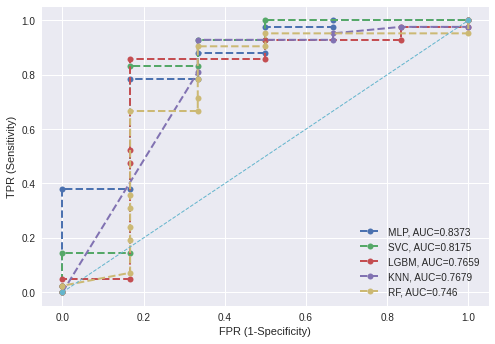

END FOLD: 1


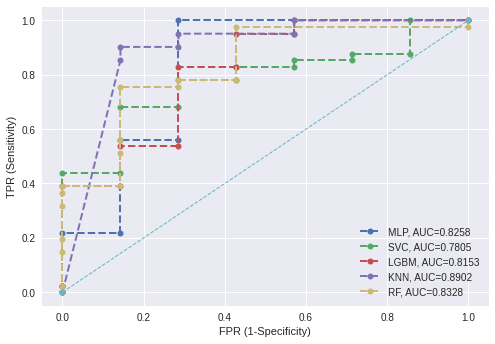

END FOLD: 2


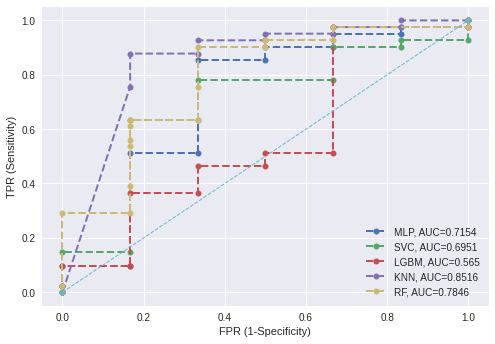

END FOLD: 3


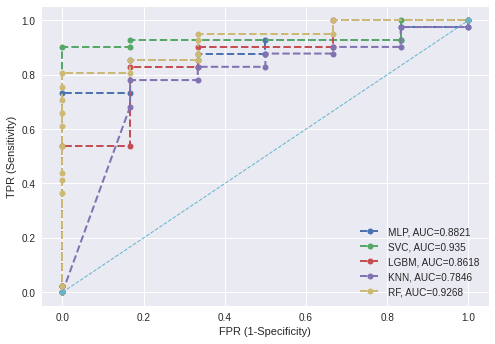

END FOLD: 4


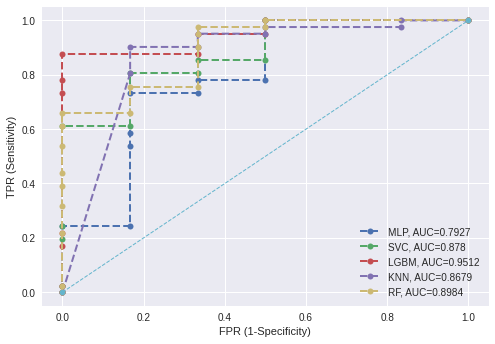

END FOLD: 5


In [126]:
#plotting ROC curves

avalon_SVC_param = {'probability':True, 'C': 1, 'gamma': 0.001, 'kernel': 'sigmoid'}
standard_KNN_param = {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'distance'}
avalon_MLP_param = {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 200, 50), 'learning_rate': 'adaptive', 'max_iter': 600, 'solver': 'adam'}
avalon_lgbm_param  ={'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'is_unbalance': True, 'learning_rate': 0.01, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 12, 'objective': 'binary', 'reg_alpha': 2, 'reg_lambda': 10, 'seed': 500, 'subsample': 0.7}
fp3_rf_param  = {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 50}
# prepare the cross-validation procedure
skf = StratifiedKFold(n_splits=5, random_state=7, shuffle=True)

#load data for FP and ground truth
X = np.load(fp_path+'avalon.npy', allow_pickle=True)
X_standard = np.load(fp_path+'standard.npy', allow_pickle=True)
X_fp3 = np.load(fp_path+'fp3.npy', allow_pickle=True)
y = np.load('./placenta_target.npy',allow_pickle=True)


count = 0
for train_index, val_index in skf.split(X,y):
    #print("TRAIN:", train_index, "TEST:", val_index)
    X_train, X_val = X[train_index], X[val_index]
    X_train_standard, X_val_standard = X_standard[train_index], X_standard[val_index]
    X_train_fp3, X_val_fp3 = X_fp3[train_index], X_fp3[val_index]
    
    y_train, y_val = y[train_index], y[val_index]
    
    #set up plotting area
    plt.figure(0).clf()
    
    plt.style.use('seaborn')
    
    
    #MLP Avalon
    model = MLPClassifier(**avalon_MLP_param)
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_val, y_pred)
    auc = round(metrics.roc_auc_score(y_val, y_pred), 4)

    plt.plot(fpr,tpr,linestyle='--',marker='.',linewidth=2, markersize=12,label="MLP, AUC="+str(auc))
    
    
    #SVC Avalon
    model = SVC(**avalon_SVC_param)
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_val, y_pred)
    auc = round(metrics.roc_auc_score(y_val, y_pred), 4)
    
    plt.plot(fpr,tpr,linestyle='--',marker='.',linewidth=2, markersize=12, label="SVC, AUC="+str(auc))
    
    
    #LGBM Avalon
    model = LGBMClassifier(**avalon_lgbm_param)
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_val, y_pred)
    auc = round(metrics.roc_auc_score(y_val, y_pred), 4)
    #print(fpr,'\n', tpr,'\n', thr)
    
    plt.plot(fpr,tpr,linestyle='--',marker= '.', linewidth=2, markersize=12, label="LGBM, AUC="+str(auc))
    
    #KNN standard
    model = KNeighborsClassifier(**standard_KNN_param)
    model.fit(X_train_standard, y_train)
    
    y_pred = model.predict_proba(X_val_standard)[:, 1]
    fpr, tpr, thr = metrics.roc_curve(y_val, y_pred)
    auc = round(metrics.roc_auc_score(y_val, y_pred), 4)
    
    #print(fpr,'\n', tpr,'\n', thr)
    
    plt.plot(fpr,tpr,linestyle='--', marker ='.', linewidth=2, markersize=12, label="KNN, AUC="+str(auc))
    
    #RF Fp3
    model = RandomForestClassifier(**fp3_rf_param)
    model.fit(X_train_fp3, y_train)
    
    y_pred = model.predict_proba(X_val_fp3)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_val, y_pred)
    auc = round(metrics.roc_auc_score(y_val, y_pred), 4)
    
    #print(fpr,tpr)
    
    plt.plot(fpr,tpr,linestyle='--',marker='.', linewidth=2, markersize=12, label="RF, AUC="+str(auc))
    
    # roc curve for tpr = fpr 
    random_probs = [0 for i in range(len(y_val))]
    p_fpr, p_tpr, _ = metrics.roc_curve(y_val, random_probs, pos_label=1)
    plt.plot(p_fpr,p_tpr,linestyle='--', marker ='.', linewidth=1, markersize=11)

    #add legend
    plt.legend()
    
    plt.xlabel("FPR (1-Specificity)")
    plt.ylabel("TPR (Sensitivity)")
    
    plt.show()
    
    count+=1
    print("END FOLD:", count)
    #break



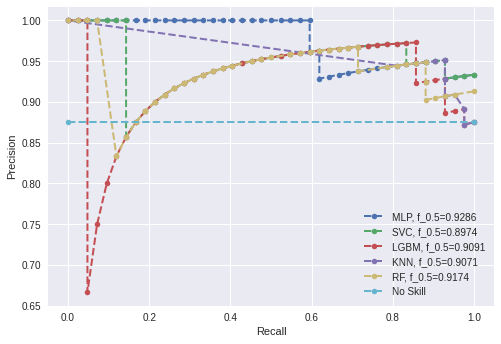

END FOLD: 1


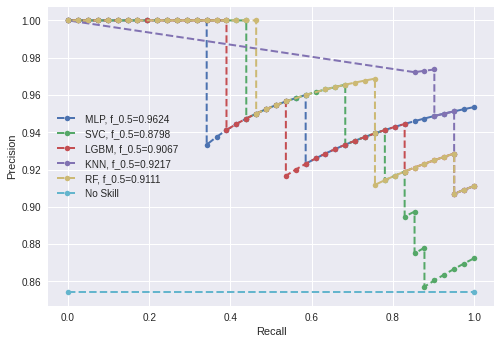

END FOLD: 2


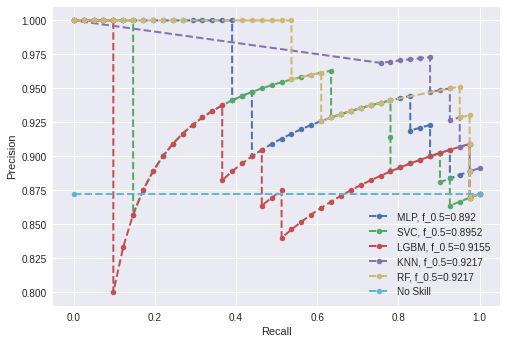

END FOLD: 3


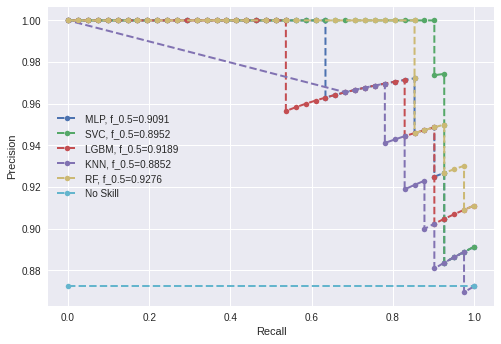

END FOLD: 4


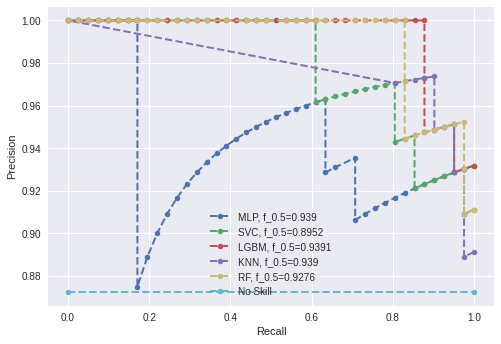

END FOLD: 5


In [183]:
#plotting PR curves

avalon_SVC_param = {'probability':True, 'C': 1, 'gamma': 0.001, 'kernel': 'sigmoid'}
standard_KNN_param = {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'distance'}
avalon_MLP_param = {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 200, 50), 'learning_rate': 'adaptive', 'max_iter': 600, 'solver': 'adam'}
avalon_lgbm_param  ={'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'is_unbalance': True, 'learning_rate': 0.01, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 12, 'objective': 'binary', 'reg_alpha': 2, 'reg_lambda': 10, 'seed': 500, 'subsample': 0.7}
fp3_rf_param  = {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 50}
# prepare the cross-validation procedure
skf = StratifiedKFold(n_splits=5, random_state=7, shuffle=True)

#load data for FP and ground truth
X = np.load(fp_path+'avalon.npy', allow_pickle=True)
X_standard = np.load(fp_path+'standard.npy', allow_pickle=True)
X_fp3 = np.load(fp_path+'fp3.npy', allow_pickle=True)
y = np.load('./placenta_target.npy',allow_pickle=True)

f_half = make_scorer(fbeta_score, beta=0.5)


count = 0
for train_index, val_index in skf.split(X,y):
    #print("TRAIN:", train_index, "TEST:", val_index)
    X_train, X_val = X[train_index], X[val_index]
    X_train_standard, X_val_standard = X_standard[train_index], X_standard[val_index]
    X_train_fp3, X_val_fp3 = X_fp3[train_index], X_fp3[val_index]
    
    y_train, y_val = y[train_index], y[val_index]
    
    #set up plotting area
    plt.figure(0).clf()
    
    plt.style.use('seaborn')
    
    
    #MLP Avalon
    model = MLPClassifier(**avalon_MLP_param)
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    yhat =  model.predict(X_val)
    
    precision, recall, _ = metrics.precision_recall_curve(y_val, y_pred)
    f1_2 = round(metrics.fbeta_score(y_val, yhat, beta=0.5),4)

    plt.plot(recall,precision,linestyle='--',marker='.',linewidth=2, markersize=11,label="MLP, f_0.5="+str(f1_2))
    
    
    #SVC Avalon
    model = SVC(**avalon_SVC_param)
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    yhat =  model.predict(X_val)
    
    precision, recall, _ = metrics.precision_recall_curve(y_val, y_pred)
    f1_2 = round(metrics.fbeta_score(y_val, yhat, beta=0.5),4)

    plt.plot(recall,precision,linestyle='--',marker='.',linewidth=2, markersize=11,label="SVC, f_0.5="+str(f1_2))
    
    #LGBM Avalon
    model = LGBMClassifier(**avalon_lgbm_param)
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    yhat =  model.predict(X_val)
    
    precision, recall, _ = metrics.precision_recall_curve(y_val, y_pred)
    f1_2 = round(metrics.fbeta_score(y_val, yhat, beta=0.5),4)

    plt.plot(recall,precision,linestyle='--',marker='.',linewidth=2, markersize=11,label="LGBM, f_0.5="+str(f1_2))
    
    #KNN standard
    model = KNeighborsClassifier(**standard_KNN_param)
    model.fit(X_train_standard, y_train)
    
    y_pred = model.predict_proba(X_val_standard)[:, 1]
    yhat =  model.predict(X_val_standard)
    
    precision, recall, _ = metrics.precision_recall_curve(y_val, y_pred)
    f1_2 = round(metrics.fbeta_score(y_val, yhat, beta=0.5),4)

    plt.plot(recall,precision,linestyle='--',marker='.',linewidth=2, markersize=11,label="KNN, f_0.5="+str(f1_2))
    
    #RF Fp3
    model = RandomForestClassifier(**fp3_rf_param)
    model.fit(X_train_fp3, y_train)
    
    y_pred = model.predict_proba(X_val_fp3)[:, 1]
    yhat =  model.predict(X_val_fp3)
    
    precision, recall, _ = metrics.precision_recall_curve(y_val, y_pred)
    f1_2 = round(metrics.fbeta_score(y_val, yhat, beta=0.5),4)

    plt.plot(recall,precision,linestyle='--',marker='.',linewidth=2, markersize=11,label="RF, f_0.5="+str(f1_2))

    no_skill = len(y_val[y_val==1]) / len(y_val)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--',marker='.',linewidth=2, markersize=11, label='No Skill')

    #add legend
    plt.legend()
    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    
    plt.show()
    
    count+=1
    print("END FOLD:", count)



In [34]:
#check for redudant drugs
df = pd.read_csv('../smiles-transformer-master/data/Placenta_barrier.csv', sep=",") #'./placenta_diabetes_drugs.csv'
PL_CID = list(df['cid'])

In [36]:
#diabetic drugs
new_CID = [
3476,
3478,
3488,
4091,
4829,
5505,
41774,
65981,
77999,
4369359,
5311309,
9887712,
10096344,
11243969,
11450633,
11949646,
16134956,
24812758,
45588096,
145994868]

In [44]:
#anti-histamines 
new_CID_2 = [
2200,
2267,
2564,
2678,
2725,
2913,
3100,
3219,
3241,
3348,
3658,
3957,
4636,
6834,
21700,
26987,
27503,
31307,
82153,
124087,
444036,
1549000,
5281004,
5281071,
5282408,
5284514,
6918155,
9865442
]

In [69]:
#hypertensive
new_CID_3 = [
1798,
2162,
2405,
2471,
2520,
2541,
2720,
3333,
3337,
3702,
3749,
3784,
3869,
4170,
4474,
4499,
4828,
4946,
5833,
33624,
39147,
39186,
41781,
65999,
107807,
5281037,
5329102,
5484727,
5493444,
54675783
]

In [38]:
for elem in new_CID:
    if elem in PL_CID:
        print("Redundant CID", elem)

Redundant CID 3488
Redundant CID 4091


In [46]:
for elem in new_CID_2:
    if elem in PL_CID:
        print("Redundant CID", elem)

In [70]:
for elem in new_CID_3:
    if elem in PL_CID:
        print("Redundant CID", elem)

In [158]:
#run inference on models with SMOTE

fp_path = './Placenta_Fingerprints/'

#Hypertension drug study
avalon_SVC_param = {'C': 1, 'gamma': 0.001, 'kernel': 'sigmoid'}
standard_KNN_param = {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'distance'}
avalon_MLP_param = {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 200, 50), 'learning_rate': 'adaptive', 'max_iter': 600, 'solver': 'adam'}
avalon_lgbm_param  ={'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'is_unbalance': True, 'learning_rate': 0.01, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 12, 'objective': 'binary', 'reg_alpha': 2, 'reg_lambda': 10, 'seed': 500, 'subsample': 0.7}
fp3_rf_param  = {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 50}

#load data for FP and ground truth
X = np.load(fp_path+'fp3.npy', allow_pickle=True)
y = np.load('./placenta_target.npy',allow_pickle=True)

#pre-processing and normalization
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

#Dimensionality Reduction
pca = PCA(n_components = 0.95)
X = pca.fit_transform(X)

#Load, Scale, and transform hypertensive drugs
X_infer = np.load('./inference_drugs_placenta/placenta_diabetes_fp3.npy', allow_pickle=True)
X_infer = scaler.transform(X_infer)
X_infer = pca.transform(X_infer)

# #Gridsearch
imba_pipeline = Pipeline(steps=[('oversample',SMOTE(random_state=7)),
                          ('model', RandomForestClassifier(**fp3_rf_param))]) #LGBMClassifier, RandomForestClassifier, KNeighborsClassifier, ExtraTreesClassifier


imba_pipeline.fit(X,y)
print("Model Trained")

Model Trained


In [52]:
# diabetes with SMOTE KNN
imba_pipeline.predict(X_infer)

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0])

In [54]:
# diabetes with SMOTE MLP
imba_pipeline.predict(X_infer)

array([0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [66]:
# diabetes with SMOTE SVC
imba_pipeline.predict(X_infer)

array([0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

In [149]:
# diabetes with SMOTE LGBM
imba_pipeline.predict(X_infer)

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [159]:
# diabetes with SMOTE RF
imba_pipeline.predict(X_infer)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [60]:
# allergy with SMOTE KNN
imba_pipeline.predict(X_infer)

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1])

In [62]:
# allergy with SMOTE MLP
imba_pipeline.predict(X_infer)

array([1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1])

In [64]:
# allergy with SMOTE SVC
imba_pipeline.predict(X_infer)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1])

In [151]:
# allergy with SMOTE LGBM
imba_pipeline.predict(X_infer)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [157]:
# allergy with SMOTE RF
imba_pipeline.predict(X_infer)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0])

In [176]:
df = pd.DataFrame ([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0], columns = ['RF_pred'])
display(df)

,RF_pred
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1


In [72]:
# Hypertensive with SMOTE KNN
imba_pipeline.predict(X_infer)

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1])

In [75]:
# Hypertensive with SMOTE MLP
imba_pipeline.predict(X_infer)

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1])

In [77]:
# Hypertensive with SMOTE SVC
imba_pipeline.predict(X_infer)

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1])

In [153]:
# Hypertensive with SMOTE LGBM
imba_pipeline.predict(X_infer)

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [155]:
# Hypertensive with SMOTE RF
imba_pipeline.predict(X_infer)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1])

In [204]:
#tanimoto density distribution
from rdkit import DataStructs

#load data for FP and ground truth
X = np.load(fp_path+'avalon.npy', allow_pickle=True)
y = np.load('./placenta_target.npy',allow_pickle=True)


X_diabetes = np.load('./inference_drugs_placenta/placenta_diabetes_avalon.npy', allow_pickle=True)
X_allergy = np.load('./inference_drugs_placenta/placenta_allergy_avalon.npy', allow_pickle=True)
X_hyper = np.load('./inference_drugs_placenta/placenta_hypertensive_avalon.npy', allow_pickle=True)

def tanimoto(v1, v2):
    """*
    Calculates tanimoto similarity for two bit vectors*
    """
    return(np.bitwise_and(v1, v2).sum() / np.bitwise_or(v1, v2).sum())


#drug comparison within placenta dataset
tan_sim = []
for i in range(len(X)-1):
    for j in range(i+1,len(X)):
        tan_sim.append(tanimoto(X[i].astype(int),X[j].astype(int)))
        
#compare diabetes drugs with the ones in dataset
tan_sim_diabetes = []
for i in range(len(X_diabetes)):
    for j in range(len(X)):
        tan_sim_diabetes.append(tanimoto(X_diabetes[i].astype(int),X[j].astype(int)))
        
#compare allergy drugs with the ones in dataset
tan_sim_allergy = []
for i in range(len(X_allergy)):
    for j in range(len(X)):
        tan_sim_allergy.append(tanimoto(X_allergy[i].astype(int),X[j].astype(int)))
        
#compare hypertension drugs with the ones in dataset
tan_sim_hypertensive = []
for i in range(len(X_hyper)):
    for j in range(len(X)):
        tan_sim_hypertensive.append(tanimoto(X_hyper[i].astype(int),X[j].astype(int)))

print(len(tan_sim),len(tan_sim_diabetes),len(tan_sim_allergy),len(tan_sim_hypertensive))

27966 4266 6636 7110


/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


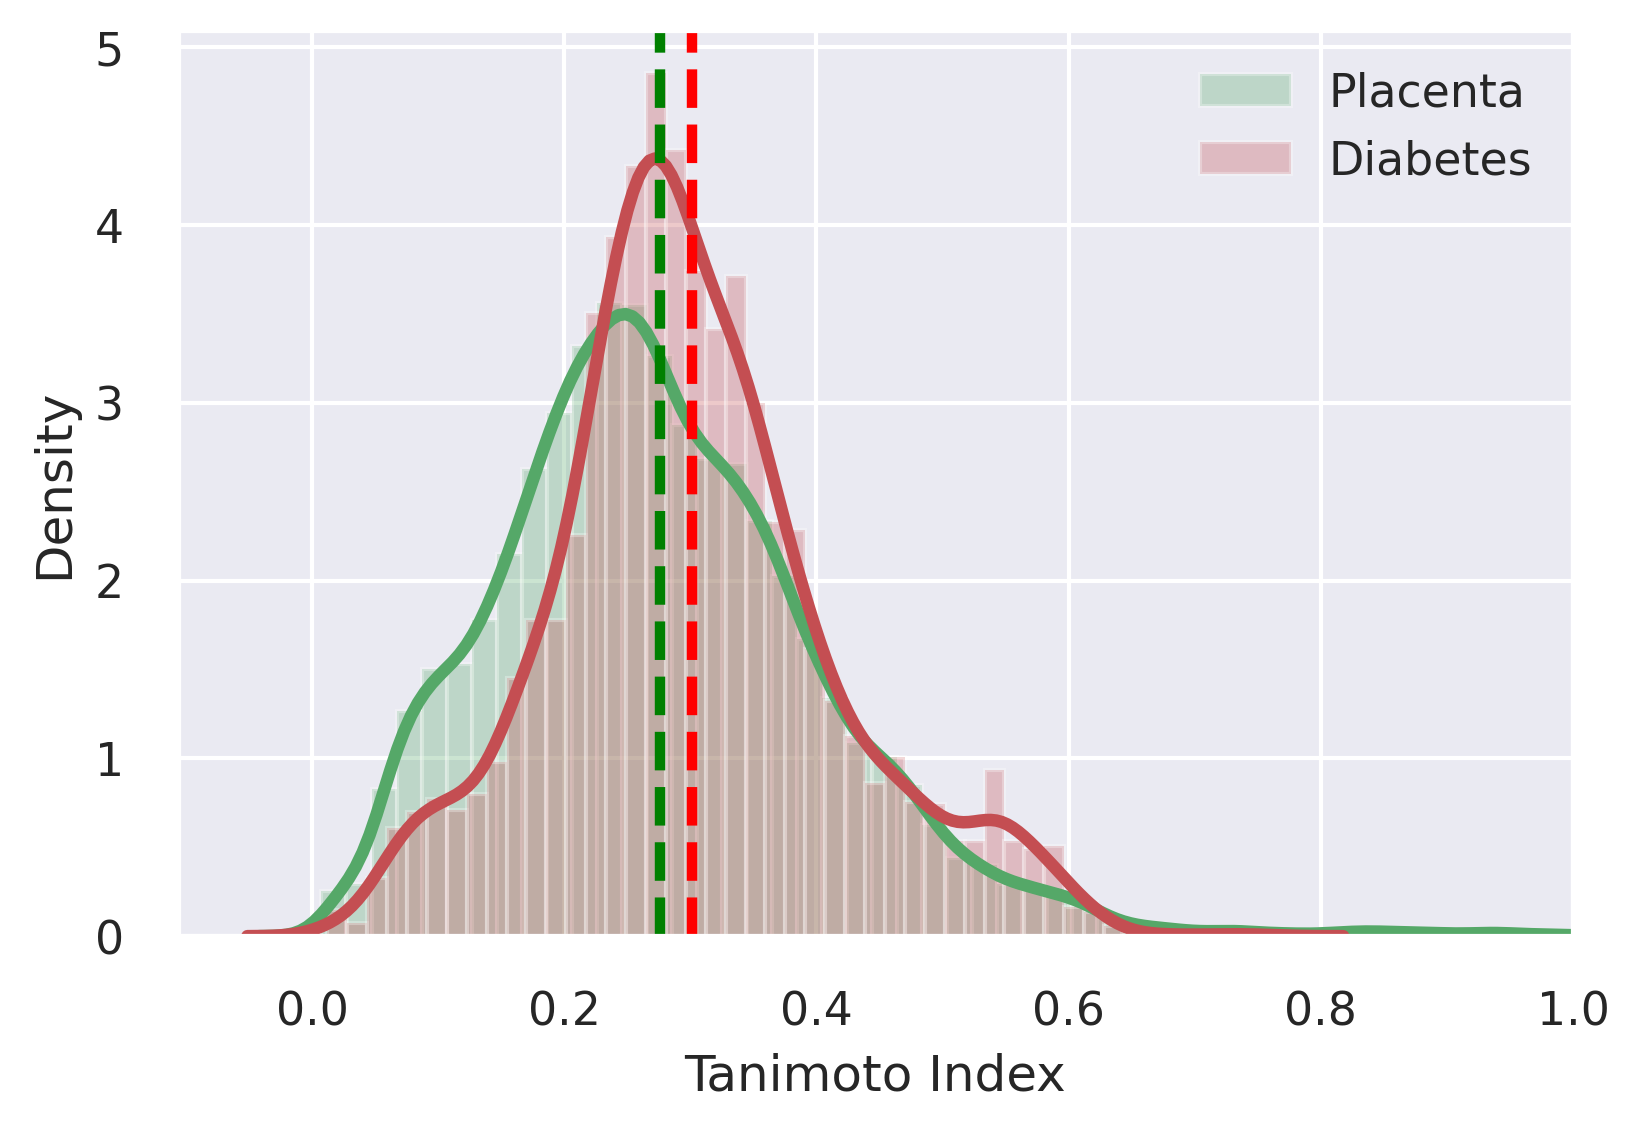

In [291]:
#sns.set_style("white")
#sns.despine()
#sns.set_style("whitegrid")
# Plot
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

matplotlib.rcParams['savefig.dpi'] = 300
matplotlib.rcParams["figure.dpi"] = 300

import seaborn as sns
sns.set()

kwargs = dict(hist_kws={'alpha':.3, }, kde_kws={'linewidth':3})

#kwargs = dict(alpha=0.5, bins=100, stacked=True)
sns.distplot(tan_sim, **kwargs, color='g', label='Placenta')
sns.distplot(tan_sim_diabetes, **kwargs, color='r', label='Diabetes')

plt.axvline(x=np.mean(tan_sim),
            ls='--', 
            lw=2.5,
            color='green')

plt.axvline(x=np.mean(tan_sim_diabetes),
            ls='--', 
            lw=2.5,
            color='red')

plt.xlabel("Tanimoto Index")
plt.xlim(right=1)
plt.ylabel("Density")
plt.legend()

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


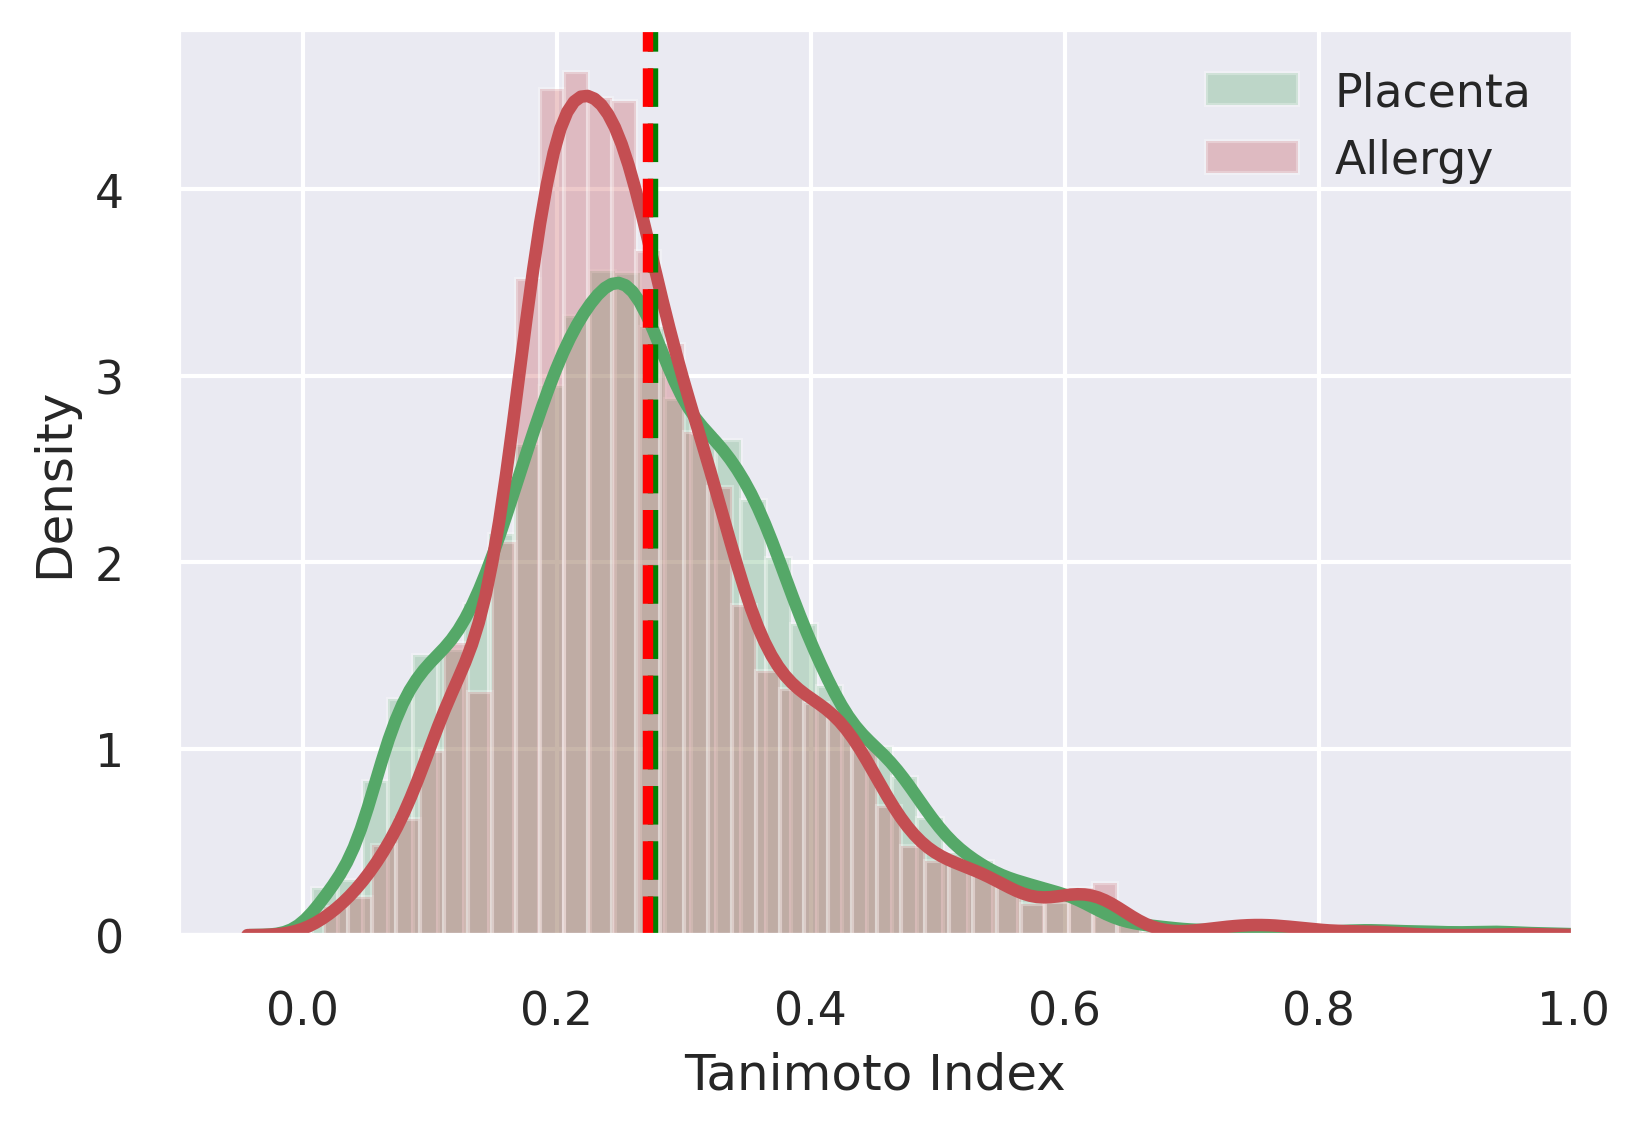

In [292]:
kwargs = dict(hist_kws={'alpha':.3, }, kde_kws={'linewidth':3})

#kwargs = dict(alpha=0.5, bins=100, stacked=True)
sns.distplot(tan_sim, **kwargs, color='g', label='Placenta')
sns.distplot(tan_sim_allergy, **kwargs, color='r', label='Allergy')

plt.axvline(x=np.mean(tan_sim),
            ls='--', 
            lw=2.5,
            color='green')

plt.axvline(x=np.mean(tan_sim_allergy),
            ls='--', 
            lw=2.5,
            color='red')

plt.xlabel("Tanimoto Index")
plt.xlim(right=1)
plt.ylabel("Density")
plt.legend()

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


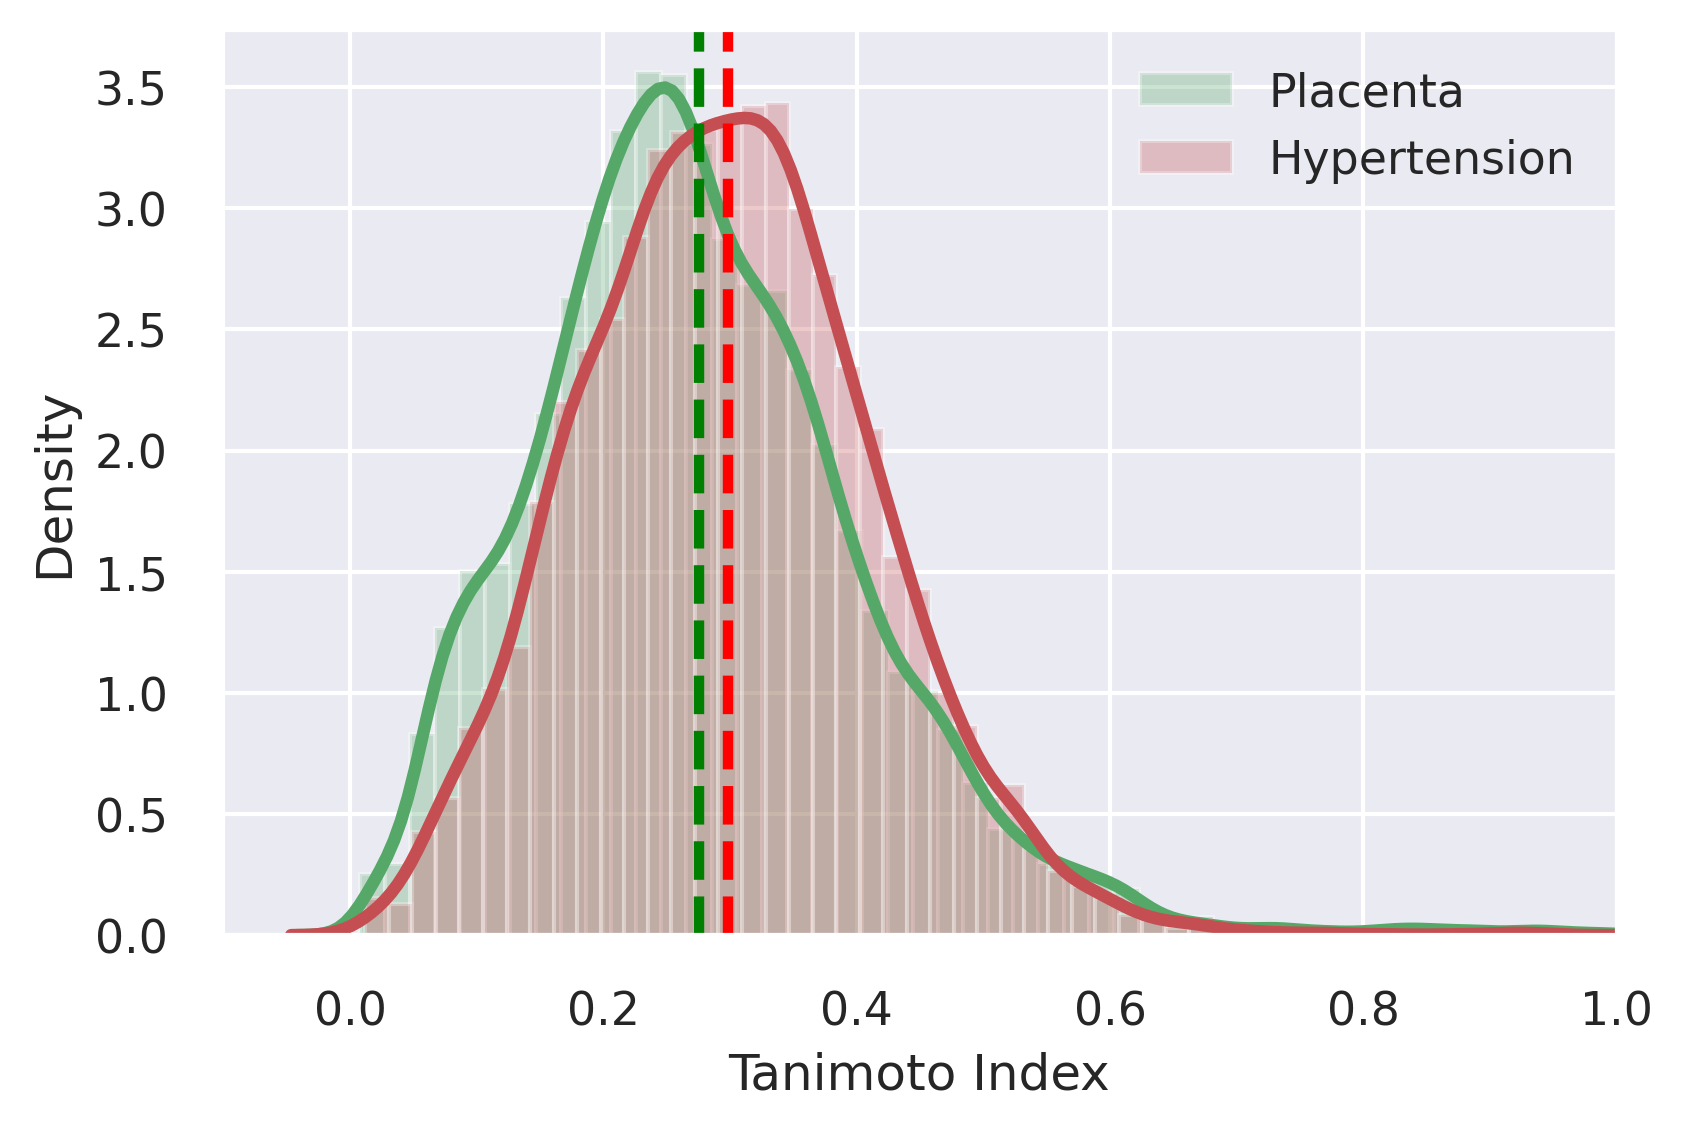

In [293]:
kwargs = dict(hist_kws={'alpha':.3, }, kde_kws={'linewidth':3})

#kwargs = dict(alpha=0.5, bins=100, stacked=True)
sns.distplot(tan_sim, **kwargs, color='g', label='Placenta')
sns.distplot(tan_sim_hypertensive, **kwargs, color='r', label='Hypertension')

plt.axvline(x=np.mean(tan_sim),
            ls='--', 
            lw=2.5,
            color='green')

plt.axvline(x=np.mean(tan_sim_hypertensive),
            ls='--', 
            lw=2.5,
            color='red')

plt.xlabel("Tanimoto Index")
plt.xlim(right=1)
plt.ylabel("Density")
plt.legend()

In [294]:
#drug comparison within diabetes dataset
tan_sim_self_diabetes = []
for i in range(len(X_diabetes)-1):
    for j in range(i+1,len(X_diabetes)):
        tan_sim_self_diabetes.append(tanimoto(X_diabetes[i].astype(int),X_diabetes[j].astype(int)))
        
#drug comparison within Allergy dataset
tan_sim_self_allergy = []
for i in range(len(X_allergy)-1):
    for j in range(i+1,len(X_allergy)):
        tan_sim_self_allergy.append(tanimoto(X_allergy[i].astype(int),X_allergy[j].astype(int)))
        

#drug comparison within Hypertenion dataset
tan_sim_self_hypertension = []
for i in range(len(X_hyper)-1):
    for j in range(i+1,len(X_hyper)):
        tan_sim_self_hypertension.append(tanimoto(X_hyper[i].astype(int),X_hyper[j].astype(int)))

/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ahus/anaconda3/envs/tf_2_5/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

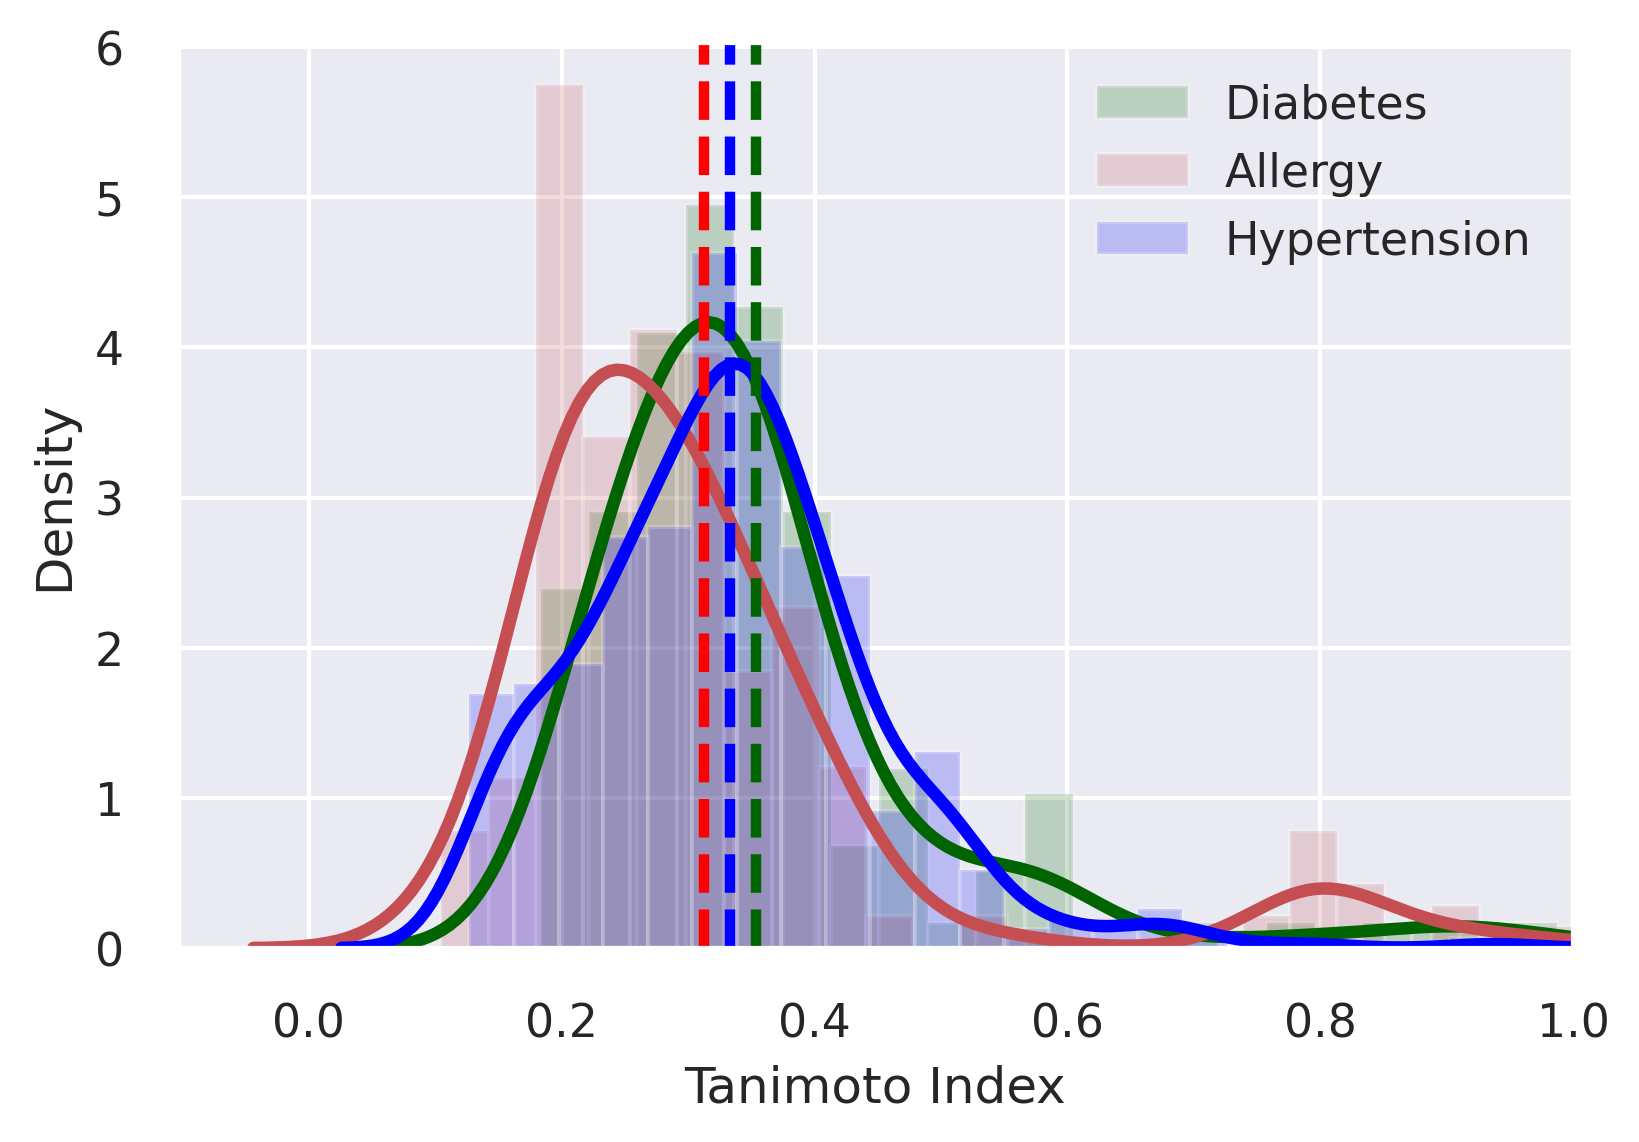

In [295]:
kwargs = dict(hist_kws={'alpha':.2, }, kde_kws={'linewidth':3})

#kwargs = dict(alpha=0.5, bins=100, stacked=True)
sns.distplot(tan_sim_self_diabetes, **kwargs, color='darkgreen', label='Diabetes')
sns.distplot(tan_sim_self_allergy, **kwargs, color='r', label='Allergy')
sns.distplot(tan_sim_self_hypertension, **kwargs, color='blue', label='Hypertension')

plt.axvline(x=np.mean(tan_sim_self_diabetes),
            ls='--', 
            lw=2.5,
            color='darkgreen')

plt.axvline(x=np.mean(tan_sim_self_allergy),
            ls='--', 
            lw=2.5,
            color='red')
             
plt.axvline(x=np.mean(tan_sim_self_hypertension),
            ls='--', 
            lw=2.5,
            color='blue')

plt.xlabel("Tanimoto Index")
plt.xlim(right=1)
plt.ylabel("Density")
plt.legend()

Text(0, 0.5, 'PC 2')

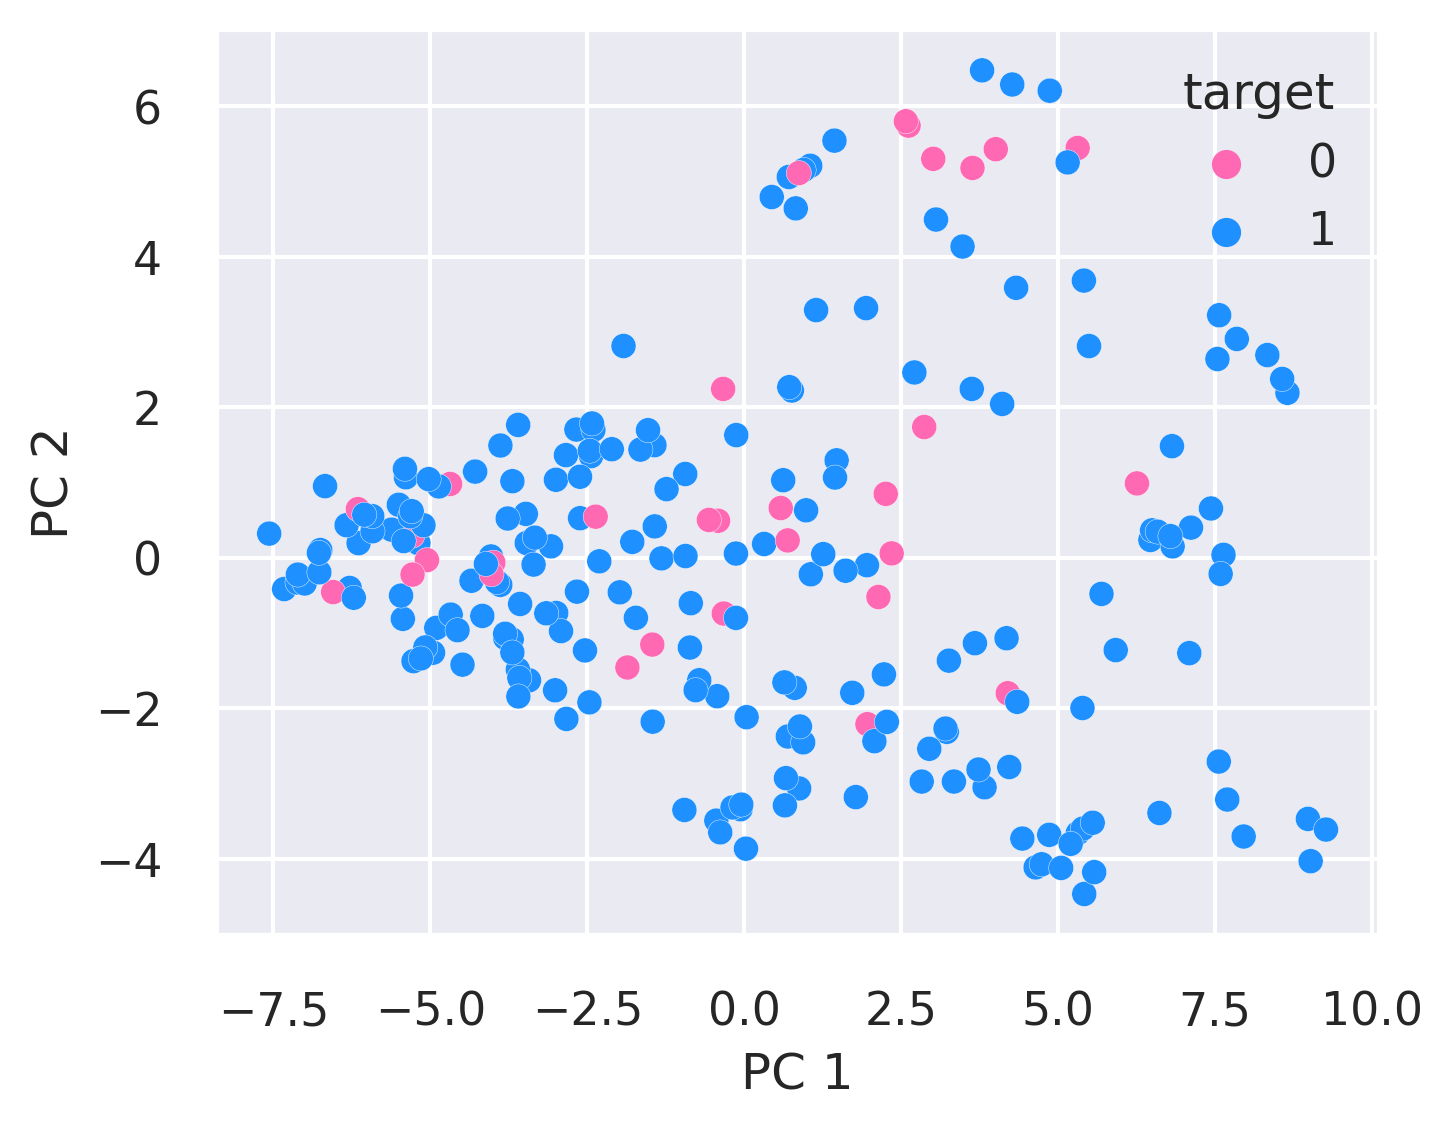

In [296]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import preprocessing

fig = plt.figure(figsize=(5, 4))

pca = PCA(n_components=2)

arr_embedded = pca.fit_transform(X)
# arr_embedded.shape
# df["PC_1"] = arr_embedded[:, 0]
# df["PC_2"] = arr_embedded[:, 1]

data = {'PC_1': arr_embedded[:, 0],
        'PC_2': arr_embedded[:, 1],
        'target': y}
  
# Create DataFrame
df = pd.DataFrame(data)

sns.scatterplot(data=df, x="PC_1", y="PC_2",
                hue="target",
                palette=sns.color_palette(["hotpink", "dodgerblue"]),
                linewidth=0.1,
                )
plt.xlabel("PC 1")
plt.ylabel("PC 2")